# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
import os
from torch.utils.data import DataLoader

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    
    image_path = "./" + data_dir
        
    train_dataset = datasets.ImageFolder(image_path, transform)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    return train_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

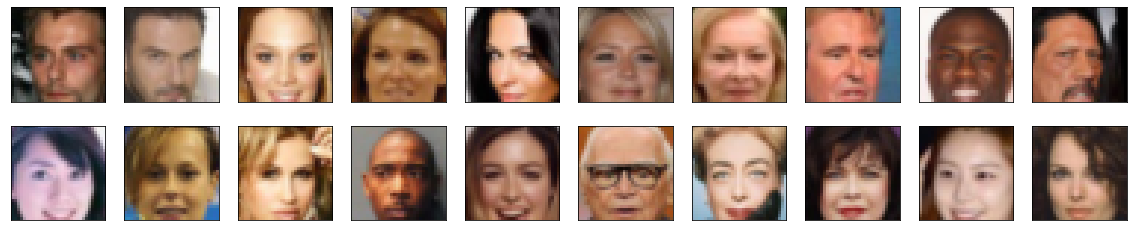

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.7725)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization"""
    layers = []
    layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                            kernel_size=kernel_size, stride=stride, padding=padding, bias=False))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, batch_norm=False) # x, y = 32, depth 32
        self.conv2 = conv(conv_dim, conv_dim * 2) #(16, 16, 64)
        self.conv3 = conv(conv_dim * 2, conv_dim*4) #(8, 8, 128)
        
        # Classification layer
        self.classifier = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        
        out = out.view(-1, self.conv_dim*4*4*4)
        out = self.classifier(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization."""
    
    layers = []
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        # Fully connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)
        
        # Convolutional layers
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2)        
        self.t_conv3 = deconv(conv_dim*2, conv_dim)
        self.t_conv4 = deconv(conv_dim, 3, batch_norm=False)

        self.tanh = nn.Tanh()
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) #(batch_size, depth, 2, 2)
        
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.relu(self.t_conv3(out))
        out = self.t_conv4(out)
        out = self.tanh(out)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
from torch.nn import init

def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    std_dev = 0.02
    mean = 0.0
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, mean, std_dev)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) * 0.9
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

lr=0.0002
beta1=0.5
beta2=0.999
# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            # Fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            d_loss = d_real_loss + d_fake_loss

            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 200

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  200] | d_loss: 1.5305 | g_loss: 0.8968
Epoch [    1/  200] | d_loss: 0.5782 | g_loss: 3.4165
Epoch [    1/  200] | d_loss: 0.4536 | g_loss: 3.6935
Epoch [    1/  200] | d_loss: 0.4437 | g_loss: 3.8087
Epoch [    1/  200] | d_loss: 0.5025 | g_loss: 3.2780
Epoch [    1/  200] | d_loss: 0.5005 | g_loss: 3.2732
Epoch [    1/  200] | d_loss: 0.4099 | g_loss: 4.3451
Epoch [    1/  200] | d_loss: 0.4900 | g_loss: 3.3825
Epoch [    1/  200] | d_loss: 0.3848 | g_loss: 4.6420
Epoch [    1/  200] | d_loss: 0.4902 | g_loss: 3.2257
Epoch [    1/  200] | d_loss: 0.3731 | g_loss: 3.3000
Epoch [    1/  200] | d_loss: 0.4874 | g_loss: 3.4115
Epoch [    1/  200] | d_loss: 0.5390 | g_loss: 3.1592
Epoch [    1/  200] | d_loss: 0.7868 | g_loss: 2.2902
Epoch [    1/  200] | d_loss: 0.7952 | g_loss: 2.8892
Epoch [    1/  200] | d_loss: 0.7067 | g_loss: 1.9496
Epoch [    2/  200] | d_loss: 0.9262 | g_loss: 1.9698
Epoch [    2/  200] | d_loss: 0.6834 | g_loss: 2.2693
Epoch [    2/  200] | d_loss

Epoch [   10/  200] | d_loss: 0.7158 | g_loss: 2.3038
Epoch [   10/  200] | d_loss: 0.8508 | g_loss: 1.7788
Epoch [   10/  200] | d_loss: 0.8643 | g_loss: 2.7414
Epoch [   10/  200] | d_loss: 1.0500 | g_loss: 1.5732
Epoch [   10/  200] | d_loss: 0.7012 | g_loss: 2.7135
Epoch [   10/  200] | d_loss: 1.0548 | g_loss: 1.2670
Epoch [   10/  200] | d_loss: 0.8003 | g_loss: 1.7640
Epoch [   10/  200] | d_loss: 0.9440 | g_loss: 1.3950
Epoch [   11/  200] | d_loss: 0.8350 | g_loss: 2.7784
Epoch [   11/  200] | d_loss: 0.7587 | g_loss: 1.6802
Epoch [   11/  200] | d_loss: 0.8270 | g_loss: 1.6424
Epoch [   11/  200] | d_loss: 0.8998 | g_loss: 1.7447
Epoch [   11/  200] | d_loss: 0.9242 | g_loss: 1.5265
Epoch [   11/  200] | d_loss: 0.8923 | g_loss: 1.5834
Epoch [   11/  200] | d_loss: 0.9146 | g_loss: 2.0448
Epoch [   11/  200] | d_loss: 0.8734 | g_loss: 2.1640
Epoch [   11/  200] | d_loss: 0.6347 | g_loss: 1.8862
Epoch [   11/  200] | d_loss: 0.7135 | g_loss: 1.9541
Epoch [   11/  200] | d_loss

Epoch [   20/  200] | d_loss: 0.9683 | g_loss: 2.9906
Epoch [   20/  200] | d_loss: 0.7016 | g_loss: 1.9941
Epoch [   20/  200] | d_loss: 0.9853 | g_loss: 1.3707
Epoch [   20/  200] | d_loss: 0.9111 | g_loss: 1.9332
Epoch [   20/  200] | d_loss: 0.8514 | g_loss: 2.3667
Epoch [   20/  200] | d_loss: 0.8291 | g_loss: 1.4538
Epoch [   20/  200] | d_loss: 0.6487 | g_loss: 1.7748
Epoch [   20/  200] | d_loss: 0.9336 | g_loss: 1.4189
Epoch [   20/  200] | d_loss: 0.9146 | g_loss: 1.7277
Epoch [   20/  200] | d_loss: 0.7514 | g_loss: 2.2417
Epoch [   20/  200] | d_loss: 0.9168 | g_loss: 2.7701
Epoch [   20/  200] | d_loss: 0.6877 | g_loss: 1.6837
Epoch [   20/  200] | d_loss: 0.7740 | g_loss: 2.0902
Epoch [   20/  200] | d_loss: 0.8396 | g_loss: 1.3420
Epoch [   20/  200] | d_loss: 0.8107 | g_loss: 2.2153
Epoch [   20/  200] | d_loss: 0.8560 | g_loss: 1.8198
Epoch [   21/  200] | d_loss: 0.8380 | g_loss: 2.2400
Epoch [   21/  200] | d_loss: 0.8648 | g_loss: 1.8820
Epoch [   21/  200] | d_loss

Epoch [   29/  200] | d_loss: 0.8700 | g_loss: 1.7801
Epoch [   29/  200] | d_loss: 0.6342 | g_loss: 2.3497
Epoch [   29/  200] | d_loss: 0.6912 | g_loss: 1.1624
Epoch [   29/  200] | d_loss: 0.5311 | g_loss: 1.5973
Epoch [   29/  200] | d_loss: 0.7588 | g_loss: 1.6418
Epoch [   29/  200] | d_loss: 0.5874 | g_loss: 1.3338
Epoch [   29/  200] | d_loss: 0.8474 | g_loss: 0.8178
Epoch [   29/  200] | d_loss: 0.7299 | g_loss: 2.6427
Epoch [   30/  200] | d_loss: 0.8489 | g_loss: 1.8417
Epoch [   30/  200] | d_loss: 0.7076 | g_loss: 3.1286
Epoch [   30/  200] | d_loss: 0.9606 | g_loss: 1.7379
Epoch [   30/  200] | d_loss: 0.6869 | g_loss: 1.9866
Epoch [   30/  200] | d_loss: 0.8148 | g_loss: 2.5946
Epoch [   30/  200] | d_loss: 0.9901 | g_loss: 1.5806
Epoch [   30/  200] | d_loss: 1.0358 | g_loss: 3.0599
Epoch [   30/  200] | d_loss: 0.7960 | g_loss: 2.1004
Epoch [   30/  200] | d_loss: 0.7689 | g_loss: 1.8857
Epoch [   30/  200] | d_loss: 0.6799 | g_loss: 1.4149
Epoch [   30/  200] | d_loss

Epoch [   39/  200] | d_loss: 1.4721 | g_loss: 1.2076
Epoch [   39/  200] | d_loss: 0.7856 | g_loss: 1.8997
Epoch [   39/  200] | d_loss: 0.8563 | g_loss: 1.1485
Epoch [   39/  200] | d_loss: 0.5753 | g_loss: 1.9117
Epoch [   39/  200] | d_loss: 0.6126 | g_loss: 1.7349
Epoch [   39/  200] | d_loss: 0.6005 | g_loss: 2.6794
Epoch [   39/  200] | d_loss: 1.0252 | g_loss: 1.8463
Epoch [   39/  200] | d_loss: 0.7864 | g_loss: 1.7503
Epoch [   39/  200] | d_loss: 0.8967 | g_loss: 2.3322
Epoch [   39/  200] | d_loss: 0.6205 | g_loss: 2.9017
Epoch [   39/  200] | d_loss: 0.7100 | g_loss: 1.5032
Epoch [   39/  200] | d_loss: 0.5890 | g_loss: 2.6232
Epoch [   39/  200] | d_loss: 0.6021 | g_loss: 2.6633
Epoch [   39/  200] | d_loss: 0.7532 | g_loss: 2.1353
Epoch [   39/  200] | d_loss: 0.5891 | g_loss: 1.7474
Epoch [   39/  200] | d_loss: 0.8141 | g_loss: 1.4780
Epoch [   40/  200] | d_loss: 0.5627 | g_loss: 3.7658
Epoch [   40/  200] | d_loss: 0.6169 | g_loss: 2.6305
Epoch [   40/  200] | d_loss

Epoch [   48/  200] | d_loss: 0.6423 | g_loss: 2.6737
Epoch [   48/  200] | d_loss: 0.6709 | g_loss: 1.6367
Epoch [   48/  200] | d_loss: 0.7785 | g_loss: 2.8089
Epoch [   48/  200] | d_loss: 0.6698 | g_loss: 2.6423
Epoch [   48/  200] | d_loss: 0.6907 | g_loss: 2.4555
Epoch [   48/  200] | d_loss: 0.7093 | g_loss: 2.9658
Epoch [   48/  200] | d_loss: 0.6278 | g_loss: 2.0094
Epoch [   48/  200] | d_loss: 0.6557 | g_loss: 2.2858
Epoch [   49/  200] | d_loss: 0.7415 | g_loss: 1.9606
Epoch [   49/  200] | d_loss: 0.5595 | g_loss: 2.6620
Epoch [   49/  200] | d_loss: 0.5184 | g_loss: 2.2981
Epoch [   49/  200] | d_loss: 0.6362 | g_loss: 2.1513
Epoch [   49/  200] | d_loss: 0.4566 | g_loss: 3.5602
Epoch [   49/  200] | d_loss: 0.6725 | g_loss: 2.7873
Epoch [   49/  200] | d_loss: 1.1435 | g_loss: 1.2123
Epoch [   49/  200] | d_loss: 0.5648 | g_loss: 2.4574
Epoch [   49/  200] | d_loss: 0.6752 | g_loss: 2.2672
Epoch [   49/  200] | d_loss: 0.5169 | g_loss: 2.9924
Epoch [   49/  200] | d_loss

Epoch [   58/  200] | d_loss: 0.6621 | g_loss: 2.6508
Epoch [   58/  200] | d_loss: 0.7594 | g_loss: 2.0236
Epoch [   58/  200] | d_loss: 0.9041 | g_loss: 2.7889
Epoch [   58/  200] | d_loss: 0.6307 | g_loss: 2.6702
Epoch [   58/  200] | d_loss: 0.6183 | g_loss: 2.8177
Epoch [   58/  200] | d_loss: 0.5486 | g_loss: 3.0204
Epoch [   58/  200] | d_loss: 0.6560 | g_loss: 1.6762
Epoch [   58/  200] | d_loss: 0.6894 | g_loss: 2.3619
Epoch [   58/  200] | d_loss: 0.6026 | g_loss: 2.5896
Epoch [   58/  200] | d_loss: 0.5010 | g_loss: 4.0075
Epoch [   58/  200] | d_loss: 0.5055 | g_loss: 3.3502
Epoch [   58/  200] | d_loss: 0.6237 | g_loss: 2.2516
Epoch [   58/  200] | d_loss: 0.8540 | g_loss: 1.8584
Epoch [   58/  200] | d_loss: 0.6196 | g_loss: 3.6520
Epoch [   58/  200] | d_loss: 0.6513 | g_loss: 2.5816
Epoch [   58/  200] | d_loss: 0.5240 | g_loss: 2.0107
Epoch [   59/  200] | d_loss: 0.6336 | g_loss: 1.9631
Epoch [   59/  200] | d_loss: 0.5311 | g_loss: 3.4753
Epoch [   59/  200] | d_loss

Epoch [   67/  200] | d_loss: 0.5295 | g_loss: 2.8506
Epoch [   67/  200] | d_loss: 0.4888 | g_loss: 3.1746
Epoch [   67/  200] | d_loss: 0.4528 | g_loss: 2.7978
Epoch [   67/  200] | d_loss: 0.5700 | g_loss: 3.3274
Epoch [   67/  200] | d_loss: 0.5075 | g_loss: 3.1740
Epoch [   67/  200] | d_loss: 0.6272 | g_loss: 3.0856
Epoch [   67/  200] | d_loss: 0.6774 | g_loss: 2.7966
Epoch [   67/  200] | d_loss: 0.4975 | g_loss: 3.4580
Epoch [   68/  200] | d_loss: 0.5390 | g_loss: 2.6174
Epoch [   68/  200] | d_loss: 0.7363 | g_loss: 3.0868
Epoch [   68/  200] | d_loss: 0.6925 | g_loss: 2.6922
Epoch [   68/  200] | d_loss: 0.4726 | g_loss: 3.2698
Epoch [   68/  200] | d_loss: 0.5505 | g_loss: 2.4684
Epoch [   68/  200] | d_loss: 0.9293 | g_loss: 2.5002
Epoch [   68/  200] | d_loss: 0.5916 | g_loss: 3.0333
Epoch [   68/  200] | d_loss: 0.5756 | g_loss: 2.7330
Epoch [   68/  200] | d_loss: 0.8985 | g_loss: 1.8782
Epoch [   68/  200] | d_loss: 0.7437 | g_loss: 2.7829
Epoch [   68/  200] | d_loss

Epoch [   77/  200] | d_loss: 0.5829 | g_loss: 2.8523
Epoch [   77/  200] | d_loss: 0.4485 | g_loss: 3.9392
Epoch [   77/  200] | d_loss: 0.6879 | g_loss: 2.2133
Epoch [   77/  200] | d_loss: 0.7485 | g_loss: 1.8878
Epoch [   77/  200] | d_loss: 0.4903 | g_loss: 3.3812
Epoch [   77/  200] | d_loss: 0.5318 | g_loss: 2.6570
Epoch [   77/  200] | d_loss: 0.6444 | g_loss: 1.7568
Epoch [   77/  200] | d_loss: 0.5985 | g_loss: 3.0756
Epoch [   77/  200] | d_loss: 0.5632 | g_loss: 3.0579
Epoch [   77/  200] | d_loss: 0.6171 | g_loss: 2.6861
Epoch [   77/  200] | d_loss: 0.6187 | g_loss: 2.0845
Epoch [   77/  200] | d_loss: 0.7651 | g_loss: 1.6230
Epoch [   77/  200] | d_loss: 0.5985 | g_loss: 2.2793
Epoch [   77/  200] | d_loss: 0.5680 | g_loss: 1.9745
Epoch [   77/  200] | d_loss: 0.6183 | g_loss: 3.1577
Epoch [   77/  200] | d_loss: 0.5178 | g_loss: 2.4059
Epoch [   78/  200] | d_loss: 1.0790 | g_loss: 2.0609
Epoch [   78/  200] | d_loss: 0.4764 | g_loss: 2.7808
Epoch [   78/  200] | d_loss

Epoch [   86/  200] | d_loss: 0.5390 | g_loss: 2.1957
Epoch [   86/  200] | d_loss: 0.6065 | g_loss: 2.4613
Epoch [   86/  200] | d_loss: 0.6064 | g_loss: 2.5790
Epoch [   86/  200] | d_loss: 0.6001 | g_loss: 3.6044
Epoch [   86/  200] | d_loss: 0.6151 | g_loss: 1.8972
Epoch [   86/  200] | d_loss: 0.4566 | g_loss: 3.4537
Epoch [   86/  200] | d_loss: 0.6411 | g_loss: 2.4217
Epoch [   86/  200] | d_loss: 0.5612 | g_loss: 3.5452
Epoch [   87/  200] | d_loss: 0.5843 | g_loss: 2.7559
Epoch [   87/  200] | d_loss: 0.8567 | g_loss: 2.1346
Epoch [   87/  200] | d_loss: 0.8522 | g_loss: 2.6242
Epoch [   87/  200] | d_loss: 0.8719 | g_loss: 1.9378
Epoch [   87/  200] | d_loss: 0.5671 | g_loss: 2.4452
Epoch [   87/  200] | d_loss: 0.4808 | g_loss: 3.0883
Epoch [   87/  200] | d_loss: 0.5021 | g_loss: 2.3173
Epoch [   87/  200] | d_loss: 0.5879 | g_loss: 2.9125
Epoch [   87/  200] | d_loss: 0.4515 | g_loss: 3.3160
Epoch [   87/  200] | d_loss: 0.4797 | g_loss: 4.4541
Epoch [   87/  200] | d_loss

Epoch [   96/  200] | d_loss: 0.5032 | g_loss: 2.5418
Epoch [   96/  200] | d_loss: 0.4414 | g_loss: 2.4704
Epoch [   96/  200] | d_loss: 0.5650 | g_loss: 2.5698
Epoch [   96/  200] | d_loss: 0.4916 | g_loss: 3.1513
Epoch [   96/  200] | d_loss: 0.5726 | g_loss: 2.7541
Epoch [   96/  200] | d_loss: 1.1807 | g_loss: 2.0082
Epoch [   96/  200] | d_loss: 0.7810 | g_loss: 2.7161
Epoch [   96/  200] | d_loss: 0.6653 | g_loss: 2.6537
Epoch [   96/  200] | d_loss: 0.6669 | g_loss: 4.1692
Epoch [   96/  200] | d_loss: 0.5347 | g_loss: 3.2818
Epoch [   96/  200] | d_loss: 0.6066 | g_loss: 2.6273
Epoch [   96/  200] | d_loss: 0.5589 | g_loss: 2.6935
Epoch [   96/  200] | d_loss: 0.8012 | g_loss: 1.6350
Epoch [   96/  200] | d_loss: 0.4991 | g_loss: 3.3083
Epoch [   96/  200] | d_loss: 0.8698 | g_loss: 3.3415
Epoch [   96/  200] | d_loss: 0.6204 | g_loss: 3.6282
Epoch [   97/  200] | d_loss: 0.7204 | g_loss: 2.9905
Epoch [   97/  200] | d_loss: 0.4995 | g_loss: 2.9295
Epoch [   97/  200] | d_loss

Epoch [  105/  200] | d_loss: 0.4823 | g_loss: 2.9500
Epoch [  105/  200] | d_loss: 0.7797 | g_loss: 1.8996
Epoch [  105/  200] | d_loss: 0.7321 | g_loss: 2.5223
Epoch [  105/  200] | d_loss: 0.5490 | g_loss: 2.2910
Epoch [  105/  200] | d_loss: 0.4837 | g_loss: 2.4127
Epoch [  105/  200] | d_loss: 0.5875 | g_loss: 2.4915
Epoch [  105/  200] | d_loss: 0.4644 | g_loss: 2.7102
Epoch [  105/  200] | d_loss: 0.5124 | g_loss: 3.2346
Epoch [  106/  200] | d_loss: 1.0692 | g_loss: 2.8246
Epoch [  106/  200] | d_loss: 0.5458 | g_loss: 2.9167
Epoch [  106/  200] | d_loss: 0.6529 | g_loss: 4.9738
Epoch [  106/  200] | d_loss: 0.5037 | g_loss: 2.5736
Epoch [  106/  200] | d_loss: 0.5398 | g_loss: 2.2607
Epoch [  106/  200] | d_loss: 0.6095 | g_loss: 3.7096
Epoch [  106/  200] | d_loss: 0.6287 | g_loss: 3.5694
Epoch [  106/  200] | d_loss: 0.5166 | g_loss: 3.1865
Epoch [  106/  200] | d_loss: 0.6662 | g_loss: 3.6862
Epoch [  106/  200] | d_loss: 0.6947 | g_loss: 2.2262
Epoch [  106/  200] | d_loss

Epoch [  115/  200] | d_loss: 0.4922 | g_loss: 2.7979
Epoch [  115/  200] | d_loss: 0.5506 | g_loss: 3.0735
Epoch [  115/  200] | d_loss: 0.4344 | g_loss: 3.8401
Epoch [  115/  200] | d_loss: 0.6019 | g_loss: 3.7584
Epoch [  115/  200] | d_loss: 0.4965 | g_loss: 3.3431
Epoch [  115/  200] | d_loss: 0.5494 | g_loss: 3.0665
Epoch [  115/  200] | d_loss: 0.4635 | g_loss: 3.3730
Epoch [  115/  200] | d_loss: 0.7574 | g_loss: 3.1773
Epoch [  115/  200] | d_loss: 0.6004 | g_loss: 3.2315
Epoch [  115/  200] | d_loss: 0.5678 | g_loss: 2.9788
Epoch [  115/  200] | d_loss: 0.4907 | g_loss: 3.2628
Epoch [  115/  200] | d_loss: 0.6698 | g_loss: 2.5685
Epoch [  115/  200] | d_loss: 0.4373 | g_loss: 3.6853
Epoch [  115/  200] | d_loss: 0.5688 | g_loss: 3.2982
Epoch [  115/  200] | d_loss: 0.4699 | g_loss: 3.4042
Epoch [  115/  200] | d_loss: 0.7494 | g_loss: 3.3487
Epoch [  116/  200] | d_loss: 0.5236 | g_loss: 2.4216
Epoch [  116/  200] | d_loss: 0.5239 | g_loss: 2.3054
Epoch [  116/  200] | d_loss

Epoch [  124/  200] | d_loss: 0.4669 | g_loss: 2.4874
Epoch [  124/  200] | d_loss: 0.9293 | g_loss: 1.9246
Epoch [  124/  200] | d_loss: 0.5123 | g_loss: 3.1407
Epoch [  124/  200] | d_loss: 0.5800 | g_loss: 2.9263
Epoch [  124/  200] | d_loss: 0.5894 | g_loss: 1.9535
Epoch [  124/  200] | d_loss: 0.5436 | g_loss: 2.0593
Epoch [  124/  200] | d_loss: 0.6047 | g_loss: 3.3157
Epoch [  124/  200] | d_loss: 0.5482 | g_loss: 2.8545
Epoch [  125/  200] | d_loss: 0.6564 | g_loss: 2.3899
Epoch [  125/  200] | d_loss: 0.5904 | g_loss: 2.2237
Epoch [  125/  200] | d_loss: 0.5431 | g_loss: 3.0987
Epoch [  125/  200] | d_loss: 0.6079 | g_loss: 3.1741
Epoch [  125/  200] | d_loss: 0.4406 | g_loss: 3.1921
Epoch [  125/  200] | d_loss: 0.6733 | g_loss: 2.0676
Epoch [  125/  200] | d_loss: 0.4874 | g_loss: 3.1854
Epoch [  125/  200] | d_loss: 0.5344 | g_loss: 3.2551
Epoch [  125/  200] | d_loss: 0.4973 | g_loss: 4.0424
Epoch [  125/  200] | d_loss: 0.5040 | g_loss: 3.4339
Epoch [  125/  200] | d_loss

Epoch [  134/  200] | d_loss: 0.5308 | g_loss: 2.1139
Epoch [  134/  200] | d_loss: 0.5289 | g_loss: 3.4298
Epoch [  134/  200] | d_loss: 0.4809 | g_loss: 3.9493
Epoch [  134/  200] | d_loss: 0.4579 | g_loss: 4.1268
Epoch [  134/  200] | d_loss: 0.4717 | g_loss: 2.4569
Epoch [  134/  200] | d_loss: 0.6041 | g_loss: 3.0352
Epoch [  134/  200] | d_loss: 0.4946 | g_loss: 3.5274
Epoch [  134/  200] | d_loss: 0.5679 | g_loss: 3.0315
Epoch [  134/  200] | d_loss: 0.5884 | g_loss: 2.9269
Epoch [  134/  200] | d_loss: 0.7041 | g_loss: 2.3435
Epoch [  134/  200] | d_loss: 0.6753 | g_loss: 2.3335
Epoch [  134/  200] | d_loss: 0.8500 | g_loss: 2.9907
Epoch [  134/  200] | d_loss: 0.7220 | g_loss: 2.2610
Epoch [  134/  200] | d_loss: 0.5627 | g_loss: 3.0905
Epoch [  134/  200] | d_loss: 0.6689 | g_loss: 2.6718
Epoch [  134/  200] | d_loss: 0.5133 | g_loss: 2.7994
Epoch [  135/  200] | d_loss: 0.4892 | g_loss: 3.3666
Epoch [  135/  200] | d_loss: 0.5624 | g_loss: 2.2442
Epoch [  135/  200] | d_loss

Epoch [  143/  200] | d_loss: 0.5255 | g_loss: 3.7719
Epoch [  143/  200] | d_loss: 0.7255 | g_loss: 2.8083
Epoch [  143/  200] | d_loss: 0.5367 | g_loss: 2.1905
Epoch [  143/  200] | d_loss: 0.5846 | g_loss: 2.0152
Epoch [  143/  200] | d_loss: 0.6808 | g_loss: 2.4077
Epoch [  143/  200] | d_loss: 0.6719 | g_loss: 2.7521
Epoch [  143/  200] | d_loss: 0.6985 | g_loss: 2.5755
Epoch [  143/  200] | d_loss: 0.6310 | g_loss: 2.9074
Epoch [  144/  200] | d_loss: 0.4587 | g_loss: 3.5162
Epoch [  144/  200] | d_loss: 0.4638 | g_loss: 2.8998
Epoch [  144/  200] | d_loss: 0.5539 | g_loss: 2.7263
Epoch [  144/  200] | d_loss: 0.5337 | g_loss: 3.8285
Epoch [  144/  200] | d_loss: 0.5040 | g_loss: 1.9490
Epoch [  144/  200] | d_loss: 0.5529 | g_loss: 2.6141
Epoch [  144/  200] | d_loss: 0.5023 | g_loss: 4.7842
Epoch [  144/  200] | d_loss: 0.5379 | g_loss: 3.8718
Epoch [  144/  200] | d_loss: 0.5285 | g_loss: 2.1957
Epoch [  144/  200] | d_loss: 0.4346 | g_loss: 3.3309
Epoch [  144/  200] | d_loss

Epoch [  153/  200] | d_loss: 1.4621 | g_loss: 2.9528
Epoch [  153/  200] | d_loss: 0.4650 | g_loss: 4.4648
Epoch [  153/  200] | d_loss: 0.6465 | g_loss: 2.0003
Epoch [  153/  200] | d_loss: 0.6384 | g_loss: 3.1980
Epoch [  153/  200] | d_loss: 0.5507 | g_loss: 4.1366
Epoch [  153/  200] | d_loss: 0.4779 | g_loss: 3.2228
Epoch [  153/  200] | d_loss: 0.5804 | g_loss: 2.1257
Epoch [  153/  200] | d_loss: 0.6864 | g_loss: 3.0445
Epoch [  153/  200] | d_loss: 0.7409 | g_loss: 2.2625
Epoch [  153/  200] | d_loss: 0.4860 | g_loss: 2.7983
Epoch [  153/  200] | d_loss: 0.4978 | g_loss: 3.5846
Epoch [  153/  200] | d_loss: 0.6740 | g_loss: 3.3504
Epoch [  153/  200] | d_loss: 0.4798 | g_loss: 2.7147
Epoch [  153/  200] | d_loss: 0.5208 | g_loss: 2.0486
Epoch [  153/  200] | d_loss: 0.5303 | g_loss: 3.6853
Epoch [  153/  200] | d_loss: 0.5447 | g_loss: 2.8192
Epoch [  154/  200] | d_loss: 1.9309 | g_loss: 2.7045
Epoch [  154/  200] | d_loss: 0.7299 | g_loss: 2.8992
Epoch [  154/  200] | d_loss

Epoch [  162/  200] | d_loss: 0.6407 | g_loss: 2.5422
Epoch [  162/  200] | d_loss: 0.5199 | g_loss: 3.0259
Epoch [  162/  200] | d_loss: 0.7820 | g_loss: 4.3412
Epoch [  162/  200] | d_loss: 0.5652 | g_loss: 2.5873
Epoch [  162/  200] | d_loss: 0.6595 | g_loss: 2.5374
Epoch [  162/  200] | d_loss: 0.6598 | g_loss: 3.7934
Epoch [  162/  200] | d_loss: 0.7582 | g_loss: 1.9901
Epoch [  162/  200] | d_loss: 0.4683 | g_loss: 2.7429
Epoch [  163/  200] | d_loss: 0.6162 | g_loss: 2.3267
Epoch [  163/  200] | d_loss: 0.6278 | g_loss: 2.4961
Epoch [  163/  200] | d_loss: 0.5372 | g_loss: 3.7688
Epoch [  163/  200] | d_loss: 0.5119 | g_loss: 2.6009
Epoch [  163/  200] | d_loss: 0.8116 | g_loss: 3.3847
Epoch [  163/  200] | d_loss: 0.6461 | g_loss: 3.1260
Epoch [  163/  200] | d_loss: 0.5974 | g_loss: 2.3975
Epoch [  163/  200] | d_loss: 0.6599 | g_loss: 2.4415
Epoch [  163/  200] | d_loss: 0.5052 | g_loss: 3.0363
Epoch [  163/  200] | d_loss: 0.5618 | g_loss: 3.3395
Epoch [  163/  200] | d_loss

Epoch [  172/  200] | d_loss: 0.7906 | g_loss: 2.0746
Epoch [  172/  200] | d_loss: 0.4938 | g_loss: 3.1947
Epoch [  172/  200] | d_loss: 0.5007 | g_loss: 3.1818
Epoch [  172/  200] | d_loss: 0.5714 | g_loss: 3.5348
Epoch [  172/  200] | d_loss: 0.9588 | g_loss: 3.1980
Epoch [  172/  200] | d_loss: 0.5120 | g_loss: 3.2326
Epoch [  172/  200] | d_loss: 0.6538 | g_loss: 3.1917
Epoch [  172/  200] | d_loss: 0.7039 | g_loss: 3.6125
Epoch [  172/  200] | d_loss: 0.4766 | g_loss: 2.9192
Epoch [  172/  200] | d_loss: 0.5471 | g_loss: 2.8404
Epoch [  172/  200] | d_loss: 0.5690 | g_loss: 3.0242
Epoch [  172/  200] | d_loss: 0.6447 | g_loss: 3.4737
Epoch [  172/  200] | d_loss: 0.4840 | g_loss: 4.1320
Epoch [  172/  200] | d_loss: 0.6362 | g_loss: 3.3143
Epoch [  172/  200] | d_loss: 0.6498 | g_loss: 2.2497
Epoch [  172/  200] | d_loss: 0.4978 | g_loss: 3.8218
Epoch [  173/  200] | d_loss: 0.4750 | g_loss: 3.5016
Epoch [  173/  200] | d_loss: 0.5660 | g_loss: 3.0318
Epoch [  173/  200] | d_loss

Epoch [  181/  200] | d_loss: 0.4753 | g_loss: 2.9881
Epoch [  181/  200] | d_loss: 0.5680 | g_loss: 2.8935
Epoch [  181/  200] | d_loss: 0.5712 | g_loss: 3.7091
Epoch [  181/  200] | d_loss: 0.5919 | g_loss: 3.8981
Epoch [  181/  200] | d_loss: 0.4794 | g_loss: 2.6038
Epoch [  181/  200] | d_loss: 0.4591 | g_loss: 3.3932
Epoch [  181/  200] | d_loss: 0.4538 | g_loss: 3.4108
Epoch [  181/  200] | d_loss: 0.5902 | g_loss: 3.2134
Epoch [  182/  200] | d_loss: 0.5474 | g_loss: 4.1371
Epoch [  182/  200] | d_loss: 0.6558 | g_loss: 3.9176
Epoch [  182/  200] | d_loss: 0.6772 | g_loss: 3.9138
Epoch [  182/  200] | d_loss: 0.4141 | g_loss: 3.3622
Epoch [  182/  200] | d_loss: 0.7688 | g_loss: 2.7466
Epoch [  182/  200] | d_loss: 0.4899 | g_loss: 4.4383
Epoch [  182/  200] | d_loss: 0.8519 | g_loss: 1.4092
Epoch [  182/  200] | d_loss: 0.4811 | g_loss: 3.2755
Epoch [  182/  200] | d_loss: 0.5241 | g_loss: 4.2576
Epoch [  182/  200] | d_loss: 0.4632 | g_loss: 2.7276
Epoch [  182/  200] | d_loss

Epoch [  191/  200] | d_loss: 0.4819 | g_loss: 3.8629
Epoch [  191/  200] | d_loss: 0.5612 | g_loss: 3.0846
Epoch [  191/  200] | d_loss: 0.5350 | g_loss: 2.4790
Epoch [  191/  200] | d_loss: 0.5207 | g_loss: 2.9751
Epoch [  191/  200] | d_loss: 0.5090 | g_loss: 3.6951
Epoch [  191/  200] | d_loss: 0.5543 | g_loss: 3.5775
Epoch [  191/  200] | d_loss: 0.4949 | g_loss: 3.2642
Epoch [  191/  200] | d_loss: 0.6011 | g_loss: 2.6467
Epoch [  191/  200] | d_loss: 0.4423 | g_loss: 3.8694
Epoch [  191/  200] | d_loss: 0.5865 | g_loss: 3.0775
Epoch [  191/  200] | d_loss: 0.6429 | g_loss: 3.3961
Epoch [  191/  200] | d_loss: 0.4637 | g_loss: 3.1937
Epoch [  191/  200] | d_loss: 0.5294 | g_loss: 2.8831
Epoch [  191/  200] | d_loss: 0.6284 | g_loss: 2.9915
Epoch [  191/  200] | d_loss: 0.4815 | g_loss: 3.2317
Epoch [  191/  200] | d_loss: 0.5412 | g_loss: 3.2962
Epoch [  192/  200] | d_loss: 1.5063 | g_loss: 2.9971
Epoch [  192/  200] | d_loss: 0.5566 | g_loss: 2.4468
Epoch [  192/  200] | d_loss

Epoch [  200/  200] | d_loss: 0.6550 | g_loss: 3.0743
Epoch [  200/  200] | d_loss: 0.4284 | g_loss: 4.1030
Epoch [  200/  200] | d_loss: 0.5822 | g_loss: 3.2535
Epoch [  200/  200] | d_loss: 0.5891 | g_loss: 3.2380
Epoch [  200/  200] | d_loss: 0.5768 | g_loss: 3.1418
Epoch [  200/  200] | d_loss: 0.6834 | g_loss: 3.1096
Epoch [  200/  200] | d_loss: 0.4946 | g_loss: 3.1089
Epoch [  200/  200] | d_loss: 0.7156 | g_loss: 3.4076


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

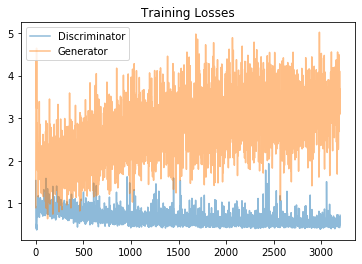

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

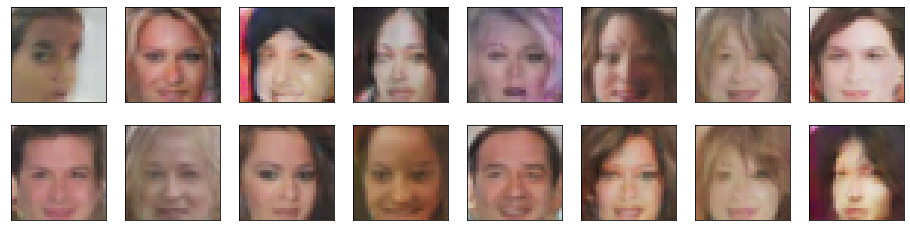

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 
* More of the generated samples appear caucasian probably because more of the real samples are also caucasion so the likelyhood of generating a face like that increases.
* There are little or no children in the real samples which is also reflected in the fake images generated.
* Having deeper model would likely pickup more details but is harder to train.
* The number of epochs does affect the clarity of the generated faces. More epochs create clearer pictures. 
* The "adversarial" part of the model can be seen in the generator and discriminator losses. The appears to take turn one "round" the generator see reduction in loss which is often paired with an increase in loss on the discriminator. Then the tred changes and loss decrease on discriminator and increases on generator.
* The generator seems to be having greater loss than the discriminator. I added one more layer to the generator to give it a bit more advantage over the discriminator to try to "ballence" the two opposing networks. This resulted in better quality image generation.


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.